In [1]:
# import the necessary Libraries 
import sys
import requests
import json

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors


import io
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans

In [2]:
response_obj = requests.get('https://en.wikipedia.org/wiki/Special_wards_of_Tokyo').text
soup = BeautifulSoup(response_obj,'lxml')
Wards_Of_Tokyo = soup.find('table', {'class':'wikitable sortable'})
### preparation of the table 

Name=[]
Kanji = []
Pop = []
Density = []
num = []
flag = []
Area = []
Major_District = []

for row in Wards_Of_Tokyo.findAll("tr"):    
    Ward = row.findAll('td')
    if len(Ward)==8: #Only extract table body not heading
        num.append(Ward[0].find(text=True))
        flag.append(Ward[1].findAll('a')) # useless
        Name.append(Ward[2])
        Kanji.append(Ward[3].find(text=True))
        Pop.append(Ward[4])
        Area.append(Ward[5].find(text=True))
        Major_District.append(Ward[7].find(text=True))
            
#++++++++++++++++++++++++++++++++++++++++++++++
#+ Area 
#++++++++++++++++++++++++++++++++++++++++++++++

#print (Area[3]) # the first element of the area needs a replacement with the true value 5100
Area = ['5100' if x=='0' else x for x in Area]
New_Area = []

# change the type of Area list 
for l in range(len(Area)):
    x=Area[l].replace(",","")
    New_Area.append(x)

New_Area=[int(s) for s in New_Area]

#print (New_Area) # the list elements are already in accordance with the table

#+++++++++++++++++++++++++++++++++++++++++++++++++++++
#+ Name of the Wards
#+++++++++++++++++++++++++++++++++++++++++++++++++++++
#print (Name) # want to select only the title part

new_names = []
for n in range(len(Name)):
    names = Name[n].findAll('a')
    new_names.append(names) 

flat_new_names_list = [item for sublist in new_names for item in sublist]

Wards_names= []
#now 
for name_wards in flat_new_names_list:
        Wards_names.append(name_wards.get('title'))


# replace the elements in the list that contains 'Tokyo' with only the ward names
replace_names={'Chiyoda, Tokyo':'Chiyoda', 'Chūō, Tokyo':'Chuo', 'Minato, Tokyo':'Minato', 
               'Sumida, Tokyo':'Sumida', 'Koto, Tokyo':'Koto', 'Ōta, Tokyo':'Ota', 'Nakano, Tokyo':'Nakano', 
               'Kita, Tokyo':'Kita', 'Arakawa, Tokyo':'Arakawa', 'Adachi, Tokyo':'Adachi', 'Edogawa, Tokyo':'Edogawa'}


Wards_names1 = [replace_names.get(n1,n1) for n1 in Wards_names]


#+++++++++++++++++++++++++++++++++++++++++++++++++++++
#+ Population
#+++++++++++++++++++++++++++++++++++++++++++++++++++++
population = []
for p in range(len(Pop)):
    pops = Pop[p].text[1:9]
    #populs = Pop[p].find('visibility:hidden;color:transparent;')
    population.append(pops) 

New_population = []
for po in range(len(population)):
    xy=population[po].replace(",","")
    New_population.append(xy)

New_population=[int(s1) for s1 in New_population]


#++++++++++++++++++++++++++++++++++++++++++++++++
#+ Major Districts
#++++++++++++++++++++++++++++++++++++++++++++++++


replace_districts = {'Nagatachō':'Nagatacho', 'Hongō':'Hongo', 'Kinshichō':'Kinshicho', 'Ōmori': 'Omori', 
                     'Kōenji':'Koenji', 'Arakawa, Machiya, ':'Arakawa', 'Ayase, ':'Ayase', 'Kasai, Koiwa\n':'Kasai'}


Major_District_names1 = [replace_districts.get(n2,n2) for n2 in Major_District]


df=pd.DataFrame(Wards_names1,columns=['Ward'])
df['Area_SqKm'] = New_Area
df['Population'] = New_population
df['Major_District'] = Major_District_names1
df.index = np.arange(1, len(df) + 1) # reset the index so that it starts from 1. 

# use of geopy geocoders
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Tokyo_explorer")
df['Major_Dist_Coord']= df['Major_District'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))
df[['Latitude', 'Longitude']] = df['Major_Dist_Coord'].apply(pd.Series)

df.drop(['Major_Dist_Coord'], axis=1, inplace=True)
# replace some of the wrong coordinates 


Lat_list = df['Latitude'].tolist()
Long_list = df['Longitude'].tolist()
replace_latitudes = {32.5093796:35.7088, 23.0131338:35.6722, -38.9047057:35.5884, -5.3498001:35.6634}
replace_longitudes = {-116.2970014:139.7601, -80.8328748:139.8061, 175.7552111:139.7279, 21.424098:139.8731}

latitudes_new = [replace_latitudes.get(n3,n3) for n3 in Lat_list]
longtitudes_new = [replace_longitudes.get(n4,n4) for n4 in Long_list]

Tokyo_df = df.drop(['Latitude', 'Longitude'], axis=1)
# #df.drop(['Longitude'], axis=1, inplace=True)

Tokyo_df['Dist_Latitude'] = latitudes_new
Tokyo_df['Dist_Longitude'] = longtitudes_new

#Tokyo_df
#print(Tokyo_df)

#Tokyo_df.to_csv('Tokyo_df_Coordinates.csv')

In [3]:
Tokyo_df = pd.read_csv('Tokyo_df_Coordinates.csv', index_col=[0])
#remove the unnamed column 
Tokyo_df.head(3)

,Ward,Area_SqKm,Population,Major_District,Dist_Latitude,Dist_Longitude
1,Chiyoda,5100,59441,Nagatacho,35.675618,139.743469
2,Chuo,14460,147620,Nihonbashi,35.684058,139.774501
3,Minato,12180,248071,Odaiba,35.619128,139.779403


In [4]:
response_obj = requests.get('https://utinokati.com/en/details/land-market-value/area/Tokyo/').text
#print (type (response_obj))
soup = BeautifulSoup(response_obj,'lxml')
#print (soup.prettify())
Price_Tokyo_Table = soup.find('table', {'class':'table-condensed'})
#Price_Tokyo_Table

In [5]:
Name=[]
Avg_price = []


for row in Price_Tokyo_Table.findAll("tr"):
    price = row.findAll('td')
    if len(price)==3: #Only extract table body not heading
#         num.append(Ward[0].find(text=True))
#         flag.append(Ward[1].findAll('a')) # useless
         Name.append(price[0].find(text=True))
         Avg_price.append(price[2].find(text=True))   

price_df = pd.DataFrame(Name,columns=['Ward'])
price_df['Avg_price_sqKm'] = Avg_price

#price_df

price_df['Avg_price_sqKm'] = price_df['Avg_price_sqKm'].map(lambda x: x.rstrip('JPY/sq.m').rstrip('0123456789'))

# Change the average price column datatype 
Avg_price_list = price_df['Avg_price_sqKm'].tolist()
New_Avg_price = []

for pr in range(len(Avg_price_list)):
    x = Avg_price_list[pr].replace(",", "")
    New_Avg_price.append(x)


Avg_price_new=[int(s) for s in New_Avg_price]

price_df.drop(['Avg_price_sqKm'], axis=1, inplace=True)

price_df['Average_Price(SqKm)'] = New_Avg_price

price_df

,Ward,Average_Price(SqKm)
0,Chiyoda-Ku,1790780
1,Chuo-Ku,2907525
2,Minato-Ku,2216266
3,Shinjuku-Ku,906709
4,Bunkyo-Ku,942727
5,Taito-Ku,1013512
6,Sumida-Ku,556183
7,Koto-Ku,574957
8,Shinagawa-Ku,715981
9,Meguro-Ku,843895


In [6]:
## Select info only for 6 relevant wards Shibuya, Sumida, Shinjuku, Toshima, Shinagawa, Minato. 
## 
pd.options.mode.chained_assignment = None
ward_list = ['Shibuya-Ku', 'Sumida-Ku', 'Shinjuku-Ku', 'Toshima-Ku', 'Shinagawa-Ku','Minato-Ku']
price_df_selected = price_df.loc[price_df['Ward'].isin(ward_list)]
price_df_selected.index = np.arange(1, len(price_df_selected) + 1)
#Ward_names = price_df_selected['Ward'].map(lambda y: str(y)[:-3]) # strip -Ku from the ward names
price_df_selected['Ward']=price_df_selected['Ward'].map(lambda y: str(y)[:-3]) 
#price_df_selected.drop(['Ward'], axis=1, inplace=True)
#price_df_selected['Ward']=Ward_names
price_df_selected

,Ward,Average_Price(SqKm)
1,Minato,2216266
2,Shinjuku,906709
3,Sumida,556183
4,Shinagawa,715981
5,Shibuya,1260688
6,Toshima,662308


In [7]:
## Similarly select those six wards from the Tokyo Wards Data-Frame
ward_list1 = ['Shibuya', 'Sumida', 'Shinjuku', 'Toshima', 'Shinagawa','Minato']
Tokyo_df_selected = Tokyo_df.loc[Tokyo_df['Ward'].isin(ward_list1)]
Tokyo_df_selected

,Ward,Area_SqKm,Population,Major_District,Dist_Latitude,Dist_Longitude
3,Minato,12180,248071,Odaiba,35.619128,139.779403
4,Shinjuku,18620,339211,Shinjuku,35.693763,139.703632
7,Sumida,18910,260358,Kinshicho,35.696752,139.814151
9,Shinagawa,17180,392492,Shinagawa,35.599252,139.738910
13,Shibuya,15080,227850,Shibuya,35.664596,139.698711
16,Toshima,22650,294673,Ikebukuro,35.730196,139.711153


In [8]:
# Merge the two dataframes according to the ward names 

Tokyo_df_selected_final = Tokyo_df_selected.merge(price_df_selected, on='Ward', how='left')
Tokyo_df_selected_final.index = np.arange(1, len(Tokyo_df_selected_final)+1)
Tokyo_df_selected_final.to_csv('Tokyo_6_Wards.csv')
Tokyo_df_selected_final

,Ward,Area_SqKm,Population,Major_District,Dist_Latitude,Dist_Longitude,Average_Price(SqKm)
1,Minato,12180,248071,Odaiba,35.619128,139.779403,2216266
2,Shinjuku,18620,339211,Shinjuku,35.693763,139.703632,906709
3,Sumida,18910,260358,Kinshicho,35.696752,139.814151,556183
4,Shinagawa,17180,392492,Shinagawa,35.599252,139.738910,715981
5,Shibuya,15080,227850,Shibuya,35.664596,139.698711,1260688
6,Toshima,22650,294673,Ikebukuro,35.730196,139.711153,662308


In [9]:
# get Tokyo, Tokyo Latitude and Longitude 

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
address = 'Tokyo'

geolocator = Nominatim(user_agent="Tokyo_explorer")
location = geolocator.geocode(address)
Tokyo_latitude = location.latitude
Tokyo_longitude = location.longitude
print('The geograpical coordinates of Tokyo are {}, {}.'.format(Tokyo_latitude, Tokyo_longitude))

The geograpical coordinates of Tokyo are 35.6828387, 139.7594549.


In [10]:
import folium
# # create map of Most Busy Areas of Tokyo using latitude and longitude values
Tokyo_6Wards = folium.Map(location=[Tokyo_latitude, Tokyo_longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(Tokyo_df_selected_final['Dist_Latitude'], Tokyo_df_selected_final['Dist_Longitude'], 
                           Tokyo_df_selected_final['Major_District']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=9,
        popup=label,
        color='magenta',
        fill=True,
        fill_color='#8020df',
        fill_opacity=0.7).add_to(Tokyo_6Wards)  
    
Tokyo_6Wards

In [11]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '' # Foursquare API version

print('My credentails:')
print('My CLIENT_ID: ' + CLIENT_ID)
print('My CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
My CLIENT_ID: ZDIYECPZNDNYWF4SRJZZXF3JAGNXYCSIYERBRCHHHR3CO1SE
My CLIENT_SECRET:DPZ3BNPLNGCA5T0NGMMCPA3Y5SMZUJGEDIZJUTKJPASVSXGR


In [12]:
radius = 1000
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'Dist_Latitude', 
                  'Dist_Longitude', 
                  'Venue', 
                  'Venue_Lat', 
                  'Venue_Long', 
                  'Venue_Category']
    
    return(nearby_venues)

In [13]:
Tokyo_6_Dist_Venues = getNearbyVenues(names=Tokyo_df_selected_final['Major_District'],
                                   latitudes=Tokyo_df_selected_final['Dist_Latitude'],
                                   longitudes=Tokyo_df_selected_final['Dist_Longitude']
                                  )

Odaiba
Shinjuku
Kinshicho
Shinagawa
Shibuya
Ikebukuro


In [14]:
print ("Shape of the Venues Dataframe: ", Tokyo_6_Dist_Venues.shape)
Tokyo_6_Dist_Venues.head(5)

Shape of the Venues Dataframe:  (592, 7)


,District,Dist_Latitude,Dist_Longitude,Venue,Venue_Lat,Venue_Long,Venue_Category
0,Odaiba,35.619128,139.779403,Miraikan (日本科学未来館),35.619332,139.776778,Science Museum
1,Odaiba,35.619128,139.779403,Miraikan Hall (未来館ホール),35.619384,139.777057,Auditorium
2,Odaiba,35.619128,139.779403,Oedo Onsen Monogatari (大江戸温泉物語),35.615481,139.777502,Hot Spring
3,Odaiba,35.619128,139.779403,Miraikan Kitchen,35.619210,139.776735,Japanese Restaurant
4,Odaiba,35.619128,139.779403,MEGA WEB HISTORY GARAGE,35.624735,139.778913,Museum


In [15]:
# Create a Data-Frame out of it to Concentrate Only on Restaurants 

Tokyo_6_Dist_Venues_only_restaurant = Tokyo_6_Dist_Venues[Tokyo_6_Dist_Venues['Venue_Category']\
                                                          .str.contains('Restaurant')].reset_index(drop=True)
Tokyo_6_Dist_Venues_only_coffee = Tokyo_6_Dist_Venues[Tokyo_6_Dist_Venues['Venue_Category']\
                                                          .str.contains('Coffee')].reset_index(drop=True) 
Tokyo_6_Dist_Venues_only_food= pd.concat([Tokyo_6_Dist_Venues_only_restaurant, Tokyo_6_Dist_Venues_only_coffee])
Tokyo_6_Dist_Venues_only_food.index = np.arange(1, len(Tokyo_6_Dist_Venues_only_food)+1)
print ("Shape of the Data-Frame with Venue Category only Food (Restaurant/Coffee): ", Tokyo_6_Dist_Venues_only_food.shape)
Tokyo_6_Dist_Venues_only_food.head(10)

Shape of the Data-Frame with Venue Category only Food (Restaurant/Coffee):  (212, 7)


,District,Dist_Latitude,Dist_Longitude,Venue,Venue_Lat,Venue_Long,Venue_Category
1,Odaiba,35.619128,139.779403,Miraikan Kitchen,35.619210,139.776735,Japanese Restaurant
2,Odaiba,35.619128,139.779403,Torimikura (鶏味座),35.624870,139.775899,Yakitori Restaurant
3,Odaiba,35.619128,139.779403,Kushiya Monogatari (串家物語),35.624928,139.775172,Kushikatsu Restaurant
4,Odaiba,35.619128,139.779403,Sutadonya (伝説のすた丼屋),35.624567,139.775412,Donburi Restaurant
5,Odaiba,35.619128,139.779403,Wahoo's Tacos & More,35.624602,139.774788,Mexican Restaurant
6,Odaiba,35.619128,139.779403,Curry Shop Mumin (インド式カレー 夢民),35.624669,139.774976,Japanese Curry Restaurant
7,Odaiba,35.619128,139.779403,Ro-Lan (楼蘭),35.624577,139.771258,Cantonese Restaurant
8,Odaiba,35.619128,139.779403,アイハウス,35.617427,139.779409,Restaurant
9,Odaiba,35.619128,139.779403,イタリア市場 ヴァリオ,35.617186,139.779482,Italian Restaurant
10,Odaiba,35.619128,139.779403,Tai-Sho-Ken (大勝軒),35.615442,139.777400,Ramen Restaurant


In [16]:
## Show in Map the Top Rated Restaruants in the Top 6 Districts

map_restaurants = folium.Map(location=[Tokyo_latitude, Tokyo_longitude], zoom_start=12, tiles="openstreetmap", 
                            attr="<a href=https://github.com/python-visualization/folium/>Folium</a>")

# set color scheme for the Venues based on the Major Districts
Districts = ['Odaiba','Shinjuku','Kinshicho','Shinagawa','Shibuya','Ikebukuro']

x = np.arange(len(Districts))

rainbow = ['#60ff60', '#ff60ff','#6060ff','#ffa560' ,'#ff6060', '#5aff66']

# add markers to the map
# markers_colors = []
for lat, lon, poi, distr in zip(Tokyo_6_Dist_Venues_only_food['Venue_Lat'], 
                                Tokyo_6_Dist_Venues_only_food['Venue_Long'], 
                                Tokyo_6_Dist_Venues_only_food['Venue_Category'], 
                                Tokyo_6_Dist_Venues_only_food['District']):
    label = folium.Popup(str(poi) + ' ' + str(distr), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[Districts.index(distr)-1],
        fill=True,
        fill_color=rainbow[Districts.index(distr)-1],
        fill_opacity=0.3).add_to(map_restaurants)
       
map_restaurants

In [17]:
### Number of Unique Categories in the Dataframe 
print('There are {} unique categories.'.format(len(Tokyo_6_Dist_Venues['Venue_Category'].unique())))
## We can check some of the categories randomly  
print (Tokyo_6_Dist_Venues[['Venue_Category']][10:20])

There are 160 unique categories.
     Venue_Category
10        Rock Club
11      Planetarium
12       Art Museum
13          Exhibit
14     Soccer Field
15        Gift Shop
16  Bubble Tea Shop
17      Music Venue
18      Coffee Shop
19             Café


In [18]:
print (Tokyo_6_Dist_Venues['Venue_Category'].value_counts())

Sake Bar                        42
Ramen Restaurant                39
Café                            26
Convenience Store               24
Coffee Shop                     22
Bar                             20
BBQ Joint                       17
Japanese Restaurant             16
Sushi Restaurant                15
Chinese Restaurant              14
Yoshoku Restaurant              10
Record Shop                     10
Hotel                            9
Park                             8
Plaza                            8
Yakitori Restaurant              8
Pub                              8
Bookstore                        7
Soba Restaurant                  7
Italian Restaurant               7
Thai Restaurant                  6
Intersection                     6
Dessert Shop                     6
Rock Club                        5
Restaurant                       5
Donburi Restaurant               5
Seafood Restaurant               5
Clothing Store                   5
Multiplex           

In [19]:
# create a dataframe of top 10 categories
Tokyo_6_Dist_Venues_Top10 = Tokyo_6_Dist_Venues['Venue_Category'].value_counts()[0:10].to_frame(name='frequency')
Tokyo_6_Dist_Venues_Top10=Tokyo_6_Dist_Venues_Top10.reset_index()
#Tokyo_6_Dist_Venues_Top10

Tokyo_6_Dist_Venues_Top10.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
Tokyo_6_Dist_Venues_Top10

,Venue_Category,Frequency
0,Sake Bar,42
1,Ramen Restaurant,39
2,Café,26
3,Convenience Store,24
4,Coffee Shop,22
5,Bar,20
6,BBQ Joint,17
7,Japanese Restaurant,16
8,Sushi Restaurant,15
9,Chinese Restaurant,14


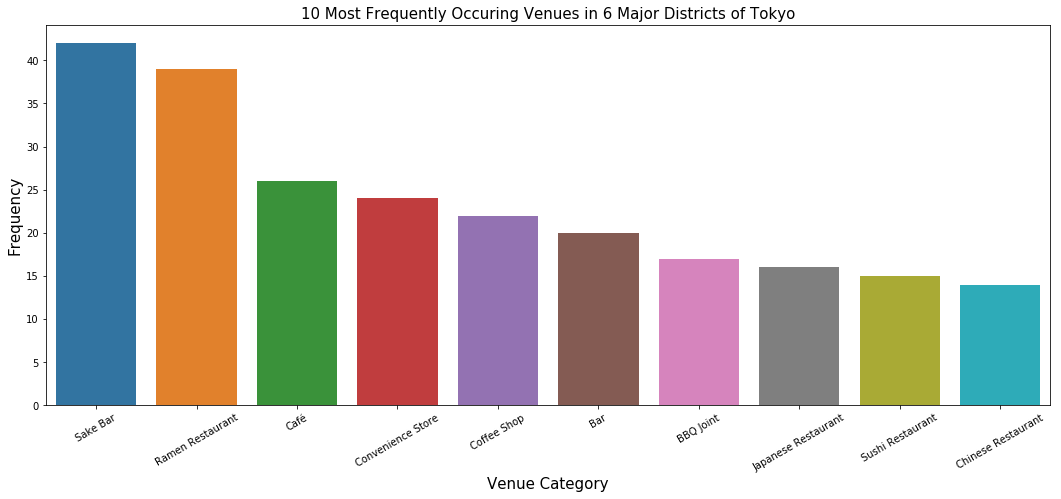

In [20]:
import seaborn as sns
fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="Venue_Category", y="Frequency", data=Tokyo_6_Dist_Venues_Top10)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('10 Most Frequently Occuring Venues in 6 Major Districts of Tokyo', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues.png", dpi=300)
plt.show()

In [21]:
### Number of Unique Categories in the Dataframe 
print('There are {} unique categories.'.format(len(Tokyo_6_Dist_Venues_only_food['Venue_Category'].unique())))
# create a dataframe of top 10 categories in Food
Tokyo_6_Dist_Venues_Top10_Food = Tokyo_6_Dist_Venues_only_food['Venue_Category'].value_counts()[0:10].to_frame(name='frequency')
Tokyo_6_Dist_Venues_Top10_Food=Tokyo_6_Dist_Venues_Top10_Food.reset_index()
#Tokyo_6_Dist_Venues_Top10_Food

Tokyo_6_Dist_Venues_Top10_Food.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
Tokyo_6_Dist_Venues_Top10_Food

There are 39 unique categories.


,Venue_Category,Frequency
0,Ramen Restaurant,39
1,Coffee Shop,22
2,Japanese Restaurant,16
3,Sushi Restaurant,15
4,Chinese Restaurant,14
5,Yoshoku Restaurant,10
6,Yakitori Restaurant,8
7,Italian Restaurant,7
8,Soba Restaurant,7
9,Thai Restaurant,6


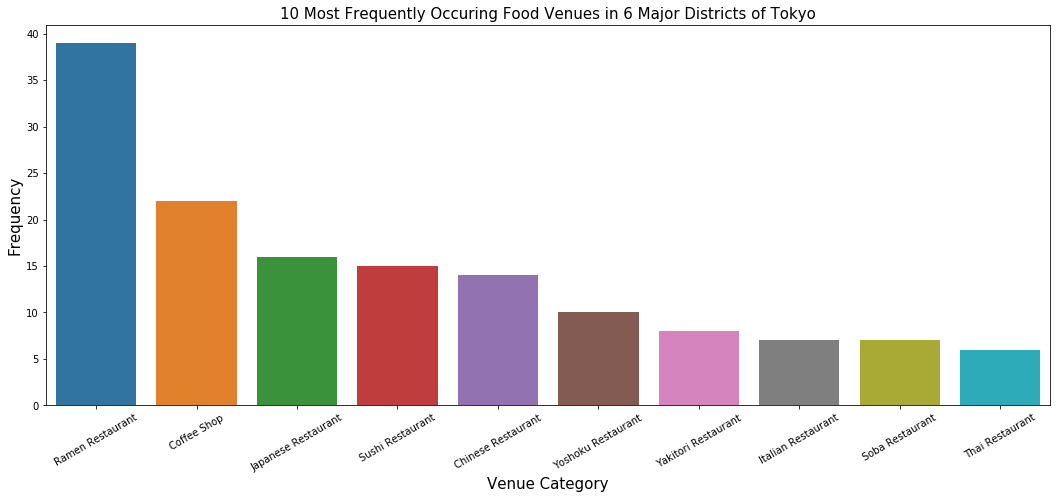

In [22]:
import seaborn as sns
fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="Venue_Category", y="Frequency", data=Tokyo_6_Dist_Venues_Top10_Food)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('10 Most Frequently Occuring Food Venues in 6 Major Districts of Tokyo', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Food_Venues.png", dpi=300)
plt.show()

In [23]:
### Use One Hot Encoding to Get More Information about the Venue Categories 
Tokyo_6_Dist_Venues_onehot = pd.get_dummies(Tokyo_6_Dist_Venues[['Venue_Category']], prefix="", prefix_sep="")

### add district column back to dataframe
Tokyo_6_Dist_Venues_onehot['District'] = Tokyo_6_Dist_Venues['District'] 
### move district column to the first column
fixed_columns = [Tokyo_6_Dist_Venues_onehot.columns[-1]] + list(Tokyo_6_Dist_Venues_onehot.columns[:-1])
Tokyo_6_Dist_Venues_onehot = Tokyo_6_Dist_Venues_onehot[fixed_columns]
###Tokyo_6_Dist_Venues_onehot.head(3)
Tokyo_6_Dist_Venues_Grouped = Tokyo_6_Dist_Venues_onehot.groupby('District').mean().reset_index()
Tokyo_6_Dist_Venues_Grouped.index = np.arange(1, len(Tokyo_6_Dist_Venues_Grouped)+1)
Tokyo_6_Dist_Venues_Grouped

,District,Accessories Store,African Restaurant,Art Museum,Asian Restaurant,Auditorium,BBQ Joint,Baby Store,Bakery,Bar,...,Train Station,Tunnel,Udon Restaurant,Unagi Restaurant,Used Bookstore,Vietnamese Restaurant,Wagashi Place,Wine Bar,Yakitori Restaurant,Yoshoku Restaurant
1,Ikebukuro,0.00,0.00,0.00000,0.01,0.00000,0.02000,0.00,0.00,0.03000,...,0.00000,0.00000,0.01,0.00,0.00,0.01,0.00,0.00,0.01000,0.05000
2,Kinshicho,0.00,0.00,0.00000,0.01,0.00000,0.03000,0.01,0.01,0.02000,...,0.00000,0.00000,0.01,0.01,0.01,0.01,0.01,0.00,0.01000,0.01000
3,Odaiba,0.00,0.00,0.01087,0.00,0.01087,0.01087,0.00,0.00,0.01087,...,0.01087,0.01087,0.00,0.00,0.00,0.00,0.00,0.00,0.01087,0.01087
4,Shibuya,0.02,0.01,0.01000,0.01,0.00000,0.01000,0.00,0.01,0.02000,...,0.00000,0.00000,0.00,0.00,0.00,0.00,0.00,0.03,0.01000,0.00000
5,Shinagawa,0.00,0.00,0.00000,0.00,0.00000,0.05000,0.00,0.02,0.02000,...,0.01000,0.00000,0.00,0.00,0.00,0.00,0.00,0.00,0.02000,0.02000
6,Shinjuku,0.00,0.00,0.00000,0.00,0.00000,0.05000,0.00,0.00,0.10000,...,0.00000,0.00000,0.01,0.01,0.00,0.00,0.00,0.01,0.02000,0.01000


In [24]:
#Top 5 venues in each of 6 Districts.
num_top_venues = 5

for places in Tokyo_6_Dist_Venues_Grouped['District']:
    print("%%%%%%%%%"+places+"%%%%%%%%")
    temp = Tokyo_6_Dist_Venues_Grouped[Tokyo_6_Dist_Venues_Grouped['District'] == places].T.reset_index()
    temp.columns = ['Venue','Freq']
    temp = temp.iloc[1:]
    temp['Freq'] = temp['Freq'].astype(float)
    temp = temp.round({'Freq': 2})
    print(temp.sort_values('Freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

%%%%%%%%%Ikebukuro%%%%%%%%
                 Venue  Freq
0             Sake Bar  0.12
1                 Café  0.08
2  Japanese Restaurant  0.06
3     Ramen Restaurant  0.05
4          Coffee Shop  0.05


%%%%%%%%%Kinshicho%%%%%%%%
                 Venue  Freq
0     Ramen Restaurant  0.12
1             Sake Bar  0.11
2          Coffee Shop  0.05
3  Japanese Restaurant  0.03
4      Thai Restaurant  0.03


%%%%%%%%%Odaiba%%%%%%%%
               Venue  Freq
0  Convenience Store  0.09
1       Intersection  0.07
2              Plaza  0.07
3        Coffee Shop  0.05
4      Shopping Mall  0.03


%%%%%%%%%Shibuya%%%%%%%%
              Venue  Freq
0              Café  0.12
1       Record Shop  0.05
2  Sushi Restaurant  0.05
3       Coffee Shop  0.05
4  Ramen Restaurant  0.05


%%%%%%%%%Shinagawa%%%%%%%%
               Venue  Freq
0  Convenience Store  0.16
1   Ramen Restaurant  0.11
2           Sake Bar  0.07
3          BBQ Joint  0.05
4               Park  0.03


%%%%%%%%%Shinjuku%%%%%%%%
      

In [25]:
## Define a Function to select the top 10 rows (According to the Values) 

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
District_top10_venues_sorted = pd.DataFrame(columns=columns)
District_top10_venues_sorted['District'] = Tokyo_6_Dist_Venues_Grouped['District']

for ind in np.arange(Tokyo_6_Dist_Venues_Grouped.shape[0]):
    District_top10_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Tokyo_6_Dist_Venues_Grouped.iloc[ind, :], num_top_venues)

    
District_top10_venues_sorted.index = np.arange(1, len(District_top10_venues_sorted)+1)
District_top10_venues_sorted.head(10)

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Ikebukuro,Sake Bar,Café,Japanese Restaurant,Yoshoku Restaurant,Ramen Restaurant,Coffee Shop,Sushi Restaurant,Chinese Restaurant,Bar,Szechuan Restaurant
2,Kinshicho,Ramen Restaurant,Sake Bar,Coffee Shop,Thai Restaurant,Japanese Restaurant,Chinese Restaurant,Café,BBQ Joint,Soba Restaurant,Pub
3,Odaiba,Convenience Store,Intersection,Plaza,Coffee Shop,Shopping Mall,Café,Exhibit,Discount Store,Clothing Store,Hotel
4,Shibuya,Café,Sushi Restaurant,Record Shop,Coffee Shop,Ramen Restaurant,French Restaurant,Wine Bar,Seafood Restaurant,Boutique,Hotel
5,Shinagawa,Convenience Store,Ramen Restaurant,Sake Bar,BBQ Joint,Sushi Restaurant,Restaurant,Park,Speakeasy,Soba Restaurant,Racecourse
6,Shinjuku,Sake Bar,Bar,Ramen Restaurant,BBQ Joint,Japanese Restaurant,Rock Club,Record Shop,Chinese Restaurant,Pub,Tonkatsu Restaurant


/home/jupyterlab/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


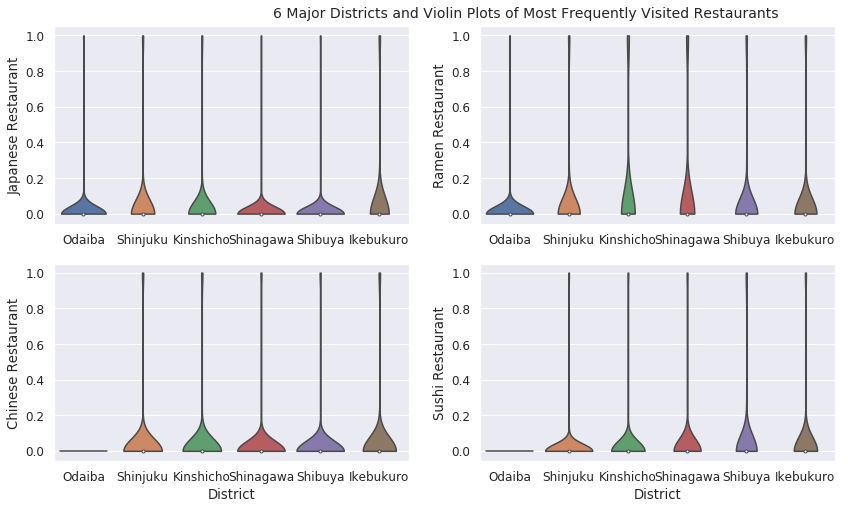

In [26]:
# Let's try Categorical plot 


fig = plt.figure(figsize=(14,8))

sns.set(font_scale=1.1)
ax = plt.subplot(2,2,1)
sns.violinplot(x="District", y="Japanese Restaurant", data=Tokyo_6_Dist_Venues_onehot, cut=0);
plt.xlabel("")
ax = plt.subplot(2,2,2)
sns.violinplot(x="District", y="Ramen Restaurant", data=Tokyo_6_Dist_Venues_onehot, cut=0);
plt.xlabel("")
plt.subplot(2,2,3)
sns.violinplot(x="District", y="Chinese Restaurant", data=Tokyo_6_Dist_Venues_onehot, cut=0);
plt.subplot(2,2,4)
sns.violinplot(x="District", y="Sushi Restaurant", data=Tokyo_6_Dist_Venues_onehot, cut=0);
#ax.title.set_text("5 Major Districts and Violin Plots of Most Frequently Visited Restaurants")
ax.text(-4.0, 1.1, '6 Major Districts and Violin Plots of Most Frequently Visited Restaurants', fontsize=14)
plt.savefig ("Violin_plots_Dist_Frequent_Restaurant.png", dpi=240)
plt.show()

[38, 47, 11, 30, 36, 28]


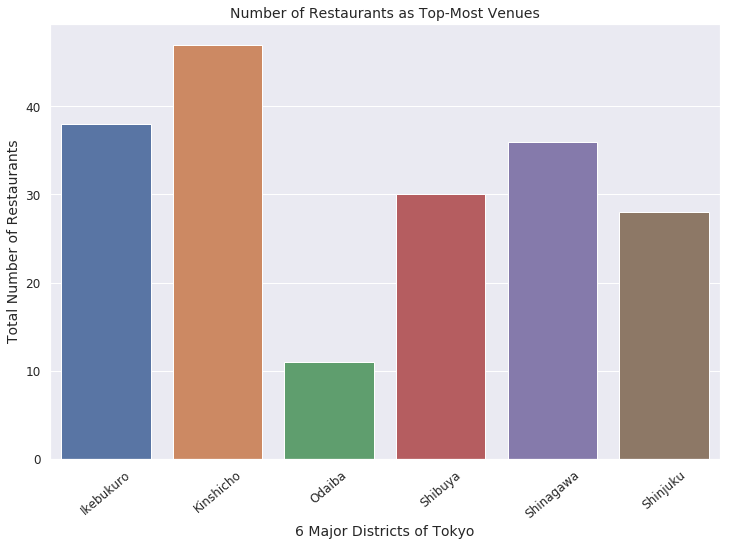

In [27]:
#try groupby to play with restaurant 
Tokyo_6_Dist_Venues_restaurant = Tokyo_6_Dist_Venues.groupby(['District'])['Venue_Category'].apply(lambda x: x[x.str.contains('Restaurant')].count())
Tokyo_6_Dist_Venues_restaurant_df = Tokyo_6_Dist_Venues_restaurant.to_frame().reset_index()
Tokyo_6_Dist_Venues_restaurant_df.columns = ['District', 'Number of Restaurant']
#Tokyo_6_Dist_Venues_restaurant.columns = ['District', 'Number of Restaurant']
Tokyo_6_Dist_Venues_restaurant_df.index = np.arange(1, len(Tokyo_6_Dist_Venues_restaurant_df)+1)

#print ("shape of the dataframe: ", Tokyo_6_Dist_Venues_restaurant_df.shape)
#print (Tokyo_6_Dist_Venues_restaurant_df.head(5))
#print (type(Tokyo_6_Dist_Venues_restaurant_df[['Number of Restaurant']]))
list_rest_no = Tokyo_6_Dist_Venues_restaurant_df['Number of Restaurant'].to_list()
print (list_rest_no)
fig = plt.figure(figsize=(12,8))
bar = sns.barplot(x='District', y='Number of Restaurant', data=Tokyo_6_Dist_Venues_restaurant_df)

bar.set_ylabel("Total Number of Restaurants", fontsize=14)
bar.set_xlabel("6 Major Districts of Tokyo", fontsize=14)
bar.set_xticklabels(bar.get_xticklabels(),rotation=40)
bar.set_title("Number of Restaurants as Top-Most Venues", fontsize=14)
#plt.savefig("No_of_Rest_as_Top_Venues.png", dpi=240)
plt.show()

In [28]:
# set number of clusters
kclusters = 3
Tokyo_grouped_clustering = Tokyo_6_Dist_Venues_Grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Tokyo_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print ("Check the 6 Cluster labels :",  kmeans.labels_[0:6])

# add clustering labels
District_top10_venues_sorted.insert(0, 'Cluster Label', kmeans.labels_)
Tokyo_6_Dist_Coordinate_Cluster_merged = Tokyo_df_selected_final

#merge the inital Tokyo Dataframe with Sorted Most Visited places for each neighborhood
Tokyo_6_Dist_Coordinate_Cluster_merged = Tokyo_6_Dist_Coordinate_Cluster_merged.join \
                                        (District_top10_venues_sorted.set_index('District'), on='Major_District')
Tokyo_6_Dist_Coordinate_Cluster_merged.head(6)

Check the 6 Cluster labels : [2 2 0 0 1 2]


,Ward,Area_SqKm,Population,Major_District,Dist_Latitude,Dist_Longitude,Average_Price(SqKm),Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Minato,12180,248071,Odaiba,35.619128,139.779403,2216266,0,Convenience Store,Intersection,Plaza,Coffee Shop,Shopping Mall,Café,Exhibit,Discount Store,Clothing Store,Hotel
2,Shinjuku,18620,339211,Shinjuku,35.693763,139.703632,906709,2,Sake Bar,Bar,Ramen Restaurant,BBQ Joint,Japanese Restaurant,Rock Club,Record Shop,Chinese Restaurant,Pub,Tonkatsu Restaurant
3,Sumida,18910,260358,Kinshicho,35.696752,139.814151,556183,2,Ramen Restaurant,Sake Bar,Coffee Shop,Thai Restaurant,Japanese Restaurant,Chinese Restaurant,Café,BBQ Joint,Soba Restaurant,Pub
4,Shinagawa,17180,392492,Shinagawa,35.599252,139.738910,715981,1,Convenience Store,Ramen Restaurant,Sake Bar,BBQ Joint,Sushi Restaurant,Restaurant,Park,Speakeasy,Soba Restaurant,Racecourse
5,Shibuya,15080,227850,Shibuya,35.664596,139.698711,1260688,0,Café,Sushi Restaurant,Record Shop,Coffee Shop,Ramen Restaurant,French Restaurant,Wine Bar,Seafood Restaurant,Boutique,Hotel
6,Toshima,22650,294673,Ikebukuro,35.730196,139.711153,662308,2,Sake Bar,Café,Japanese Restaurant,Yoshoku Restaurant,Ramen Restaurant,Coffee Shop,Sushi Restaurant,Chinese Restaurant,Bar,Szechuan Restaurant


In [29]:
# create map
map_clusters = folium.Map(location=[Tokyo_latitude, Tokyo_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Tokyo_6_Dist_Coordinate_Cluster_merged['Dist_Latitude'], 
                                  Tokyo_6_Dist_Coordinate_Cluster_merged['Dist_Longitude'], 
                                  Tokyo_6_Dist_Coordinate_Cluster_merged['Major_District'], 
                                  Tokyo_6_Dist_Coordinate_Cluster_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [30]:
# create map
map_restaurants10 = folium.Map(location=[Tokyo_latitude, Tokyo_longitude], tiles='cartodbpositron', 
                               attr="<a href=https://github.com/python-visualization/folium/>Folium</a>")

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
#rainbow = ['#00ff00', '#ff00ff','#0000ff','#ffa500' ,'#ff0000']
Districts = ['Odaiba','Shinjuku','Kinshicho','Shinagawa','Shibuya','Ikebukuro']

# add markers to the map
for lat, lon, poi, cluster in zip(Tokyo_6_Dist_Coordinate_Cluster_merged['Dist_Latitude'], 
                                  Tokyo_6_Dist_Coordinate_Cluster_merged['Dist_Longitude'], 
                                  Tokyo_6_Dist_Coordinate_Cluster_merged['Major_District'], 
                                  Tokyo_6_Dist_Coordinate_Cluster_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=list_rest_no[Districts.index(poi)]*0.5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_restaurants10)
       
map_restaurants10

In [31]:
Tokyo_Cluster1 = Tokyo_6_Dist_Coordinate_Cluster_merged.loc[Tokyo_6_Dist_Coordinate_Cluster_merged['Cluster Label'] == 0, 
                                    Tokyo_6_Dist_Coordinate_Cluster_merged.columns[[3] + list(range(4, Tokyo_6_Dist_Coordinate_Cluster_merged.shape[1]))]]
print ("No of Neighbourhood in Cluster Label 0: %d" %(Tokyo_Cluster1.shape[0]))
Tokyo_Cluster1

No of Neighbourhood in Cluster Label 0: 2


,Major_District,Dist_Latitude,Dist_Longitude,Average_Price(SqKm),Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Odaiba,35.619128,139.779403,2216266,0,Convenience Store,Intersection,Plaza,Coffee Shop,Shopping Mall,Café,Exhibit,Discount Store,Clothing Store,Hotel
5,Shibuya,35.664596,139.698711,1260688,0,Café,Sushi Restaurant,Record Shop,Coffee Shop,Ramen Restaurant,French Restaurant,Wine Bar,Seafood Restaurant,Boutique,Hotel


In [32]:
Tokyo_Cluster2 = Tokyo_6_Dist_Coordinate_Cluster_merged.loc[Tokyo_6_Dist_Coordinate_Cluster_merged['Cluster Label'] == 1, 
                                    Tokyo_6_Dist_Coordinate_Cluster_merged.columns[[3] + list(range(4, Tokyo_6_Dist_Coordinate_Cluster_merged.shape[1]))]]
print ("No of Neighbourhood in Cluster Label 1: %d" %(Tokyo_Cluster2.shape[0]))
Tokyo_Cluster2

No of Neighbourhood in Cluster Label 1: 1


,Major_District,Dist_Latitude,Dist_Longitude,Average_Price(SqKm),Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Shinagawa,35.599252,139.73891,715981,1,Convenience Store,Ramen Restaurant,Sake Bar,BBQ Joint,Sushi Restaurant,Restaurant,Park,Speakeasy,Soba Restaurant,Racecourse


In [33]:
Tokyo_Cluster3 = Tokyo_6_Dist_Coordinate_Cluster_merged.loc[Tokyo_6_Dist_Coordinate_Cluster_merged['Cluster Label'] == 2, 
                                    Tokyo_6_Dist_Coordinate_Cluster_merged.columns[[3] + list(range(4, Tokyo_6_Dist_Coordinate_Cluster_merged.shape[1]))]]
print ("No of Neighbourhood in Cluster Label 2: %d" %(Tokyo_Cluster3.shape[0]))
Tokyo_Cluster3

No of Neighbourhood in Cluster Label 2: 3


,Major_District,Dist_Latitude,Dist_Longitude,Average_Price(SqKm),Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Shinjuku,35.693763,139.703632,906709,2,Sake Bar,Bar,Ramen Restaurant,BBQ Joint,Japanese Restaurant,Rock Club,Record Shop,Chinese Restaurant,Pub,Tonkatsu Restaurant
3,Kinshicho,35.696752,139.814151,556183,2,Ramen Restaurant,Sake Bar,Coffee Shop,Thai Restaurant,Japanese Restaurant,Chinese Restaurant,Café,BBQ Joint,Soba Restaurant,Pub
6,Ikebukuro,35.730196,139.711153,662308,2,Sake Bar,Café,Japanese Restaurant,Yoshoku Restaurant,Ramen Restaurant,Coffee Shop,Sushi Restaurant,Chinese Restaurant,Bar,Szechuan Restaurant
